In [5]:
# import packages
import cftime
import gc
import glob
import intake
import sys

import cartopy as cy
import cartopy.crs as ccrs
import cmcrameri.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr

from params import savepath, homedir

from myfunctions import global_mean_60s
plt.style.use('science.mplstyle')
mpl.rcParams['axes.linewidth'] = 1

# reload imports
%load_ext autoreload
%autoreload


IndentationError: expected an indented block after function definition on line 35 (myfunctions.py, line 38)

In [165]:
def max_month_imm(swe_imm):
    data_filled = np.nan_to_num(swe_imm, nan=-999)
    maxmonth = np.nanmedian(np.nanargmax(data_filled,axis = 3),axis=2).astype(int)# .shape
    i, j = np.meshgrid(np.arange(swe_imm.shape[0]), np.arange(swe_imm.shape[1]), indexing='ij')
    swei_maxmonth = swe_imm[i, j,:,maxmonth]
    swei_max_masked = swei_maxmonth[(maxmonth > 0),:]
    return swei_max_masked, maxmonth

def max_swe_3m(maxmonth, data):
    targmonth = maxmonth.astype(int) 
    yr_indices = np.arange(165)[:, None, None, None]
    i_indices = np.arange(160)[None, :, None, None]
    j_indices = np.arange(320)[None, None, :, None]
    time_indices = yr_indices * 12 + targmonth
    time_indices_with_offsets = time_indices[..., None] + np.array([-2, -1])
    selected_values = data[time_indices_with_offsets, i_indices, j_indices]
    values = np.nansum(selected_values, axis=-1).reshape(-1,160,320)
    values[:,~(maxmonth > 0)] = np.nan
    return values

In [153]:
maxmonth = maxmonth245
data = swe_hist['snw_model_mean'].data
targmonth = maxmonth.astype(int) 
yr_indices = np.arange(165)[:, None, None, None]
i_indices = np.arange(160)[None, :, None, None]
j_indices = np.arange(320)[None, None, :, None]
time_indices = yr_indices * 12 + targmonth
time_indices_with_offsets = time_indices[..., None] + np.array([-2,-1, 0])
selected_values = data[time_indices_with_offsets, i_indices, j_indices]
values = np.nansum(selected_values, axis=(1,-1)).reshape(-1,160,320)
values[:,~(maxmonth > 0)] = np.nan

In [2]:
## load intermodel mean swe, swei, pr, tas
swe_hist = xr.open_dataset(savepath + 'snw_model_mean_historical.nc')
swe_245 = xr.open_dataset(savepath + 'snw_model_mean_ssp245.nc')
swe_585 = xr.open_dataset(savepath + 'snw_model_mean_ssp585.nc')

pr_hist = xr.open_dataset(savepath + 'pr_model_mean_historical.nc')
pr_245 = xr.open_dataset(savepath + 'pr_model_mean_ssp245.nc')
pr_585 = xr.open_dataset(savepath + 'pr_model_mean_ssp585.nc')
tas_hist = xr.open_dataset(savepath + 'tas_model_mean_historical.nc')
tas_245 = xr.open_dataset(savepath + 'tas_model_mean_ssp245.nc')
tas_585 = xr.open_dataset(savepath + 'tas_model_mean_ssp585.nc')



In [3]:
## make baselines 
pr_baseline = pr_hist.sel(time = pr_hist.time.dt.year.isin(range(1850,1950))).squeeze()
pr_monthly_mean = pr_hist.groupby(pr_hist['time.month']).mean()
pr_monthly_mean_baseline = pr_baseline.groupby(pr_baseline['time.month']).mean()
tas_baseline = tas_hist.sel(time = tas_hist.time.dt.year.isin(range(1850,1950))).squeeze()
tas_monthly_mean = tas_hist.groupby(tas_hist['time.month']).mean()
tas_monthly_mean_baseline = tas_baseline.groupby(tas_baseline['time.month']).mean()

NameError: name 'global_mean_60s' is not defined

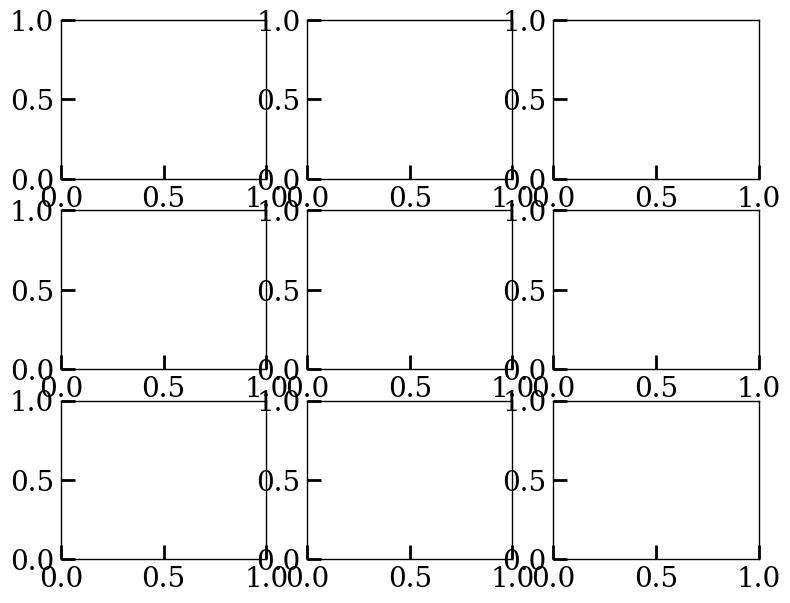

In [4]:
fig,axs=plt.subplots(3,3)
axs[0,0].plot(np.nanmean(global_mean_60s(tas_hist['tas_model_mean']), axis = (1,2)))
axs[0,0].set_ylabel('tas')
axs[0,0].set_title('hist')
axs[1,0].plot(np.nanmean(global_mean_60s(pr_hist['pr_model_mean']), axis = (1,2)))
axs[1,0].set_ylabel('pr')
axs[2,0].plot(np.nanmean(global_mean_60s(swe_hist['snw_model_mean']),axis = (1,2)))
axs[2,0].set_ylabel('snw')
axs[0,1].plot(np.nanmean(global_mean_60s(tas_245['tas_model_mean']), axis = (1,2)))
axs[0,1].set_title('245')
axs[1,1].plot(np.nanmean(global_mean_60s(pr_245['pr_model_mean']), axis = (1,2)))
axs[2,1].plot(np.nanmean(global_mean_60s(swe_245['snw_model_mean']), axis = (1,2)))
axs[0,2].plot(np.nanmean(global_mean_60s(tas_585['tas_model_mean']), axis = (1,2)))
axs[0,2].set_title('585')
axs[1,2].plot(np.nanmean(global_mean_60s(pr_585['pr_model_mean']), axis = (1,2)))
axs[2,2].plot(np.nanmean(global_mean_60s(swe_585['snw_model_mean']), axis = (1,2)))
plt.show()

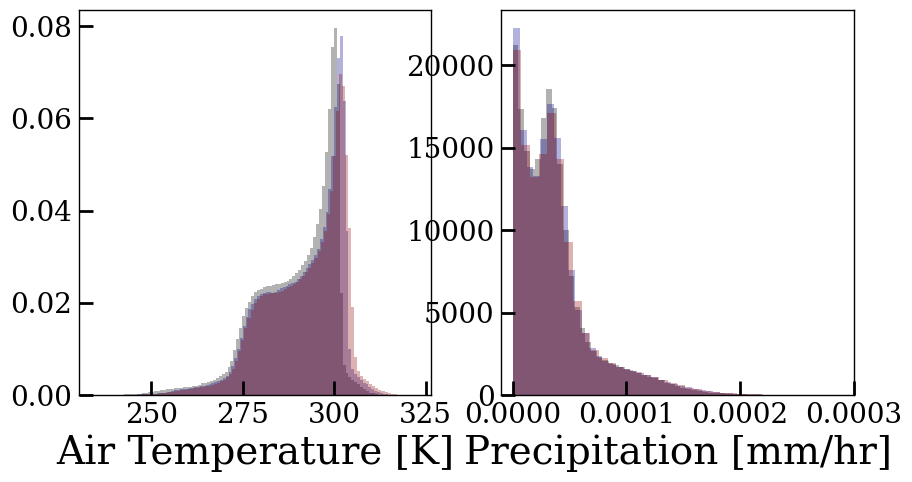

In [126]:
fig,axs = plt.subplots(1,2, figsize=(10,5))
axs[0].set_xlabel('Air Temperature [K]')
axs[0].hist(global_mean_60s(tas_hist['tas_model_mean']).data.flatten(), bins = 100, label = 'hist', density = True, alpha = 0.3)
axs[0].hist(global_mean_60s(tas_245['tas_model_mean']).data.flatten(), bins = 100, label = 'SSP2-4.5', density = True, alpha = 0.3, color = 'darkblue')
axs[0].hist(global_mean_60s(tas_585['tas_model_mean']).data.flatten(), bins = 100, label = 'SSP5-8.5', density = True, alpha = 0.3, color = 'darkred')
axs[0].legend
axs[1].set_xlabel('Precipitation [mm/hr]')
axs[1].hist(global_mean_60s(pr_hist['pr_model_mean']).data.flatten(),bins =100,  density = True, alpha = 0.3)
axs[1].hist(global_mean_60s(pr_245['pr_model_mean']).data.flatten(), bins = 100, density = True, alpha = 0.3, color = 'darkblue')
axs[1].hist(global_mean_60s(pr_585['pr_model_mean']).data.flatten(), bins = 100, density = True, alpha = 0.3, color = 'darkred')
axs[1].set_xlim((-0.00001,0.0003))
plt.show()

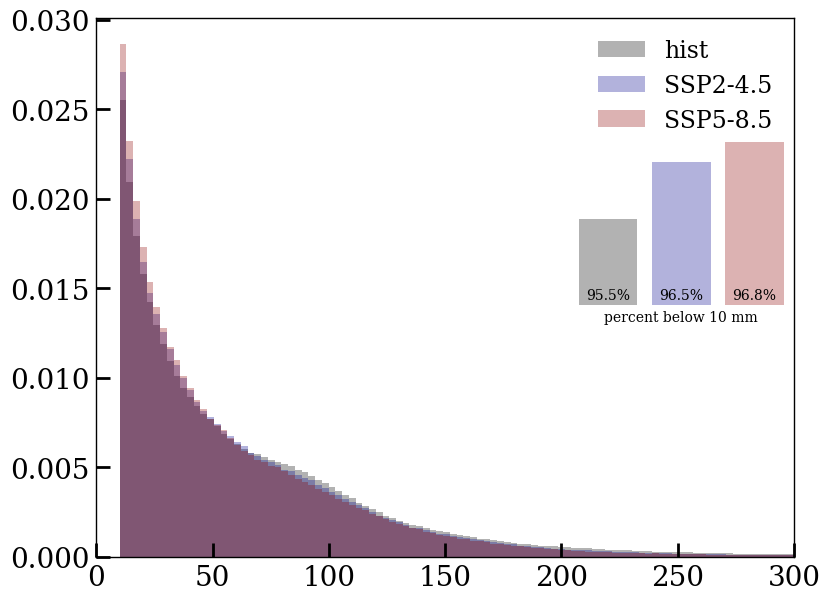

In [125]:
fig,ax=plt.subplots()
sh = global_mean_60s(swe_hist['snw_model_mean']).data.flatten()
s2 = global_mean_60s(swe_245['snw_model_mean']).data.flatten()
s5 =  global_mean_60s(swe_585['snw_model_mean']).data.flatten()
ax.hist(sh[(sh > 10) & (sh < 300)], bins = 100, density = True, label = 'hist', alpha = 0.3)
ax.hist(s2[(s2 > 10) & (s2 < 300)], bins = 100, density = True, label = 'SSP2-4.5', alpha = 0.3, color = 'darkblue')
ax.hist(s5[(s5 > 10) & (s5 < 300)], bins = 100, density = True, label = 'SSP5-8.5', alpha = 0.3, color = 'darkred')
ax.set_xlim((0,300))
ax.legend(loc = 'upper right')
nh = len(sh[sh<=10])/len(sh)
n2 = len(s2[s2<=10])/len(s2)
n5 = len(s5[s5<=10])/len(s5)
ax_inset = plt.axes([0.65,0.47,0.25,0.25], frameon = False)
ax_inset.bar([0],[nh], color = 'k', alpha = 0.3)
ax_inset.bar([1],[n2], color = 'darkblue', alpha = 0.3)
ax_inset.bar([2],[n5], color = 'darkred', alpha = 0.3)
ax_inset.set_xlabel('percent below 10 mm', fontsize = 10)
for i, value in enumerate([nh, n2, n5]):
    ax_inset.text(i, 0.941, f"{100*value:.1f}%", ha='center', fontsize = 10)
ax_inset.set_ylim((0.94,0.97))
ax_inset.set_xticks([])
ax_inset.set_yticks([])
plt.show()

(0.9547393933548447, 0.9645071089778504, 0.9679052911673929)

In [10]:
gc.collect()
pr_long585 = xr.concat([pr_hist,pr_585],dim = 'time')
tas_long585 = xr.concat([tas_hist,tas_585],dim = 'time')
pr_long245  = xr.concat([pr_hist,pr_245],dim = 'time')
tas_long245 = xr.concat([tas_hist,tas_245],dim = 'time')

tmp = pr_long585['pr_model_mean'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(pr_monthly_mean_baseline['pr_model_mean'].data[np.newaxis,:,:,:],250,axis=0)
pr_585_anom = tmp - baselinetmp
tmp = tas_long585['tas_model_mean'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(tas_monthly_mean_baseline['tas_model_mean'].data[np.newaxis,:,:,:],250,axis=0)
tas_585_anom = tmp - baselinetmp
tas_585_anom[:,:,:,160] = np.nan

tmp = pr_long245['pr_model_mean'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(pr_monthly_mean_baseline['pr_model_mean'].data[np.newaxis,:,:,:],250,axis=0)
pr_245_anom = tmp - baselinetmp
tmp = tas_long245['tas_model_mean'].data.reshape((-1,12,160,320)) 
baselinetmp = np.repeat(tas_monthly_mean_baseline['tas_model_mean'].data[np.newaxis,:,:,:],250,axis=0)
tas_245_anom = tmp - baselinetmp
tas_245_anom[:,:,:,160] = np.nan


del tmp
del baselinetmp
gc.collect()

years = [0, 110, 200]
print([1850 + y for y in years])

pr_anom585 = pr_585_anom.transpose((2,3,0,1))
tas_anom585 = tas_585_anom.transpose((2,3,0,1))
pr_anom245 = pr_245_anom.transpose((2,3,0,1))
tas_anom245 = tas_245_anom.transpose((2,3,0,1))

tas_cutoff =  0 # np.nanpercentile(tas_anom245,67)
#np.nanpercentile(tas_monthly_mean_baseline['tas_model_mean'].data,33)
pr_cutoff =  0 #np.nanpercentile(pr_anom245,33)
#np.nanpercentile(pr_monthly_mean_baseline['pr_model_mean'].data,67)

dd245 = (swei245 < -0.8) & (tas_anom245 <= tas_cutoff) & (pr_anom245 < pr_cutoff) # dry drought
wd245 = (swei245 < -0.8) & (tas_anom245 > tas_cutoff) & (pr_anom245 >= pr_cutoff) # warm drought
dwd245 = (swei245 < -0.8) & (tas_anom245 > tas_cutoff) & (pr_anom245 < pr_cutoff) # dry warm drought
nd245 = (swei245 < -0.8) & (tas_anom245 <= tas_cutoff) & (pr_anom245 >= pr_cutoff) # neither dry nor warm
d245 = (swei245 < -0.8)

dd585 = (swei585 < -0.8) & (tas_anom585 <= tas_cutoff) & (pr_anom585 < pr_cutoff)
wd585 = (swei585 < -0.8) & (tas_anom585 > tas_cutoff) & (pr_anom585 >= pr_cutoff)
dwd585 = (swei585 < -0.8) & (tas_anom585 > tas_cutoff) & (pr_anom585 < pr_cutoff)
nd585 = (swei585 < -0.8) & (tas_anom585 <= tas_cutoff) & (pr_anom585 >= pr_cutoff)
d585 = (swei585 < -0.8)

y = pr_hist['lat']
x = pr_hist['lon']
snowmask =np.nansum(swe_hist['snw_model_mean'],axis = (0) ) < 50

plotdata = []
for starty in years:
    for dataset in [wd245,dwd245,dd245,d245,wd585,dwd585,dd585,d585]:
        tmp = dataset[:,:,starty:starty+50,:]
        tmp = np.nansum(tmp,axis = (2,3)).astype(float)
        tmp[(y>60)| (y < -60)] = np.nan
        tmp[snowmask] = np.nan
        plotdata.append(tmp)


[1850, 1960, 2050]


In [11]:
print (1850, 1850 + 50)
print (1960, 1970 + 50)
print (2050, 2050 + 50)

1850 1900
1960 2020
2050 2100


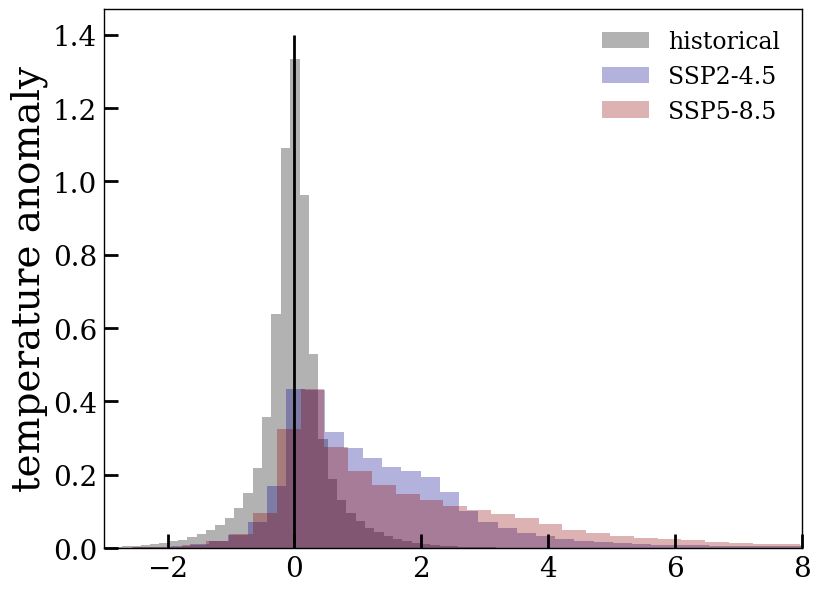

In [129]:
fig,ax= plt.subplots()
ax.hist(tas_anom245[:,:,0:85,:].flatten(),bins = 100,alpha = 0.3, label = 'historical', density = True)
ax.hist(tas_anom245[:,:,85:,:].flatten(),bins = 100,alpha = 0.3, label = 'SSP2-4.5', density = True, color = 'darkblue')
ax.hist(tas_anom585[:,:,85:,:].flatten(),bins = 100,alpha = 0.3, label = 'SSP5-8.5', density = True, color = 'darkred')
ax.vlines(tas_cutoff,0,1.4)
ax.set_ylabel('temperature anomaly')
ax.set_xlim((-3,8))
plt.legend()
plt.show()

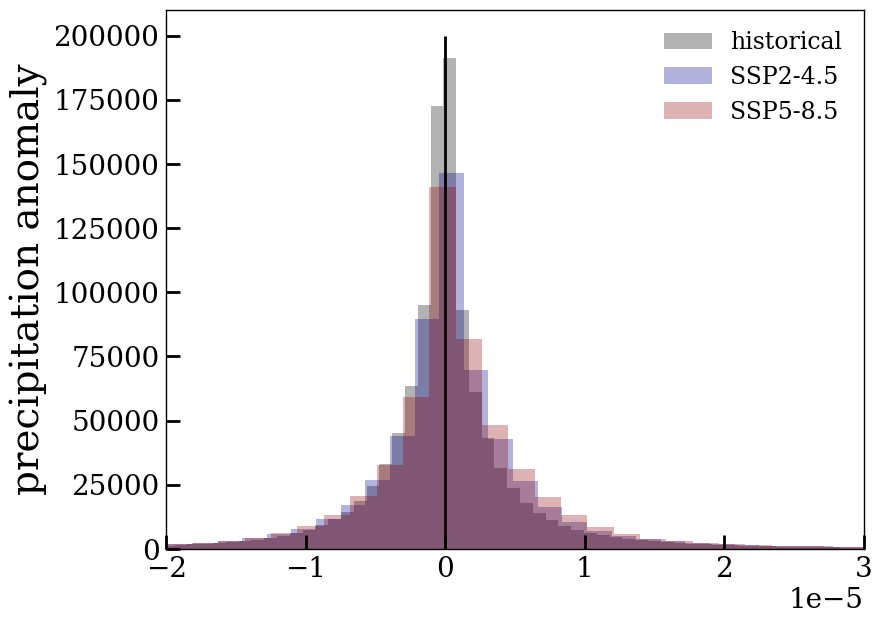

In [130]:
fig,ax= plt.subplots()
ax.hist(pr_anom245[:,:,0:85,:].flatten(),bins = 400,alpha = 0.3, label = 'historical', density = True)
ax.hist(pr_anom245[:,:,85:,:].flatten(),bins = 400,alpha = 0.3, label = 'SSP2-4.5', density = True, color = 'darkblue')
ax.hist(pr_anom585[:,:,85:,:].flatten(),bins = 400,alpha = 0.3, label = 'SSP5-8.5', density = True, color = 'darkred')
ax.set_ylabel('precipitation anomaly')
plt.legend()
ax.vlines(pr_cutoff,0,2e5)
ax.set_xlim((-0.00002,0.00003))
# ax.set_xticks([-0.00005,0,0.00005])
plt.show()

In [14]:
plotdata_sev = []
for starty in years:
    for i,dataset in enumerate([wd245,dwd245,dd245,d245,wd585,dwd585,dd585,d585]):
        if i <=3:
            tmp = swei245.copy()
        else: tmp = swei585.copy()
        tmp = tmp[:,:,starty:starty+50,:]
        tmp_mask = dataset[:,:,starty:starty+50,:]
        tmp[~tmp_mask] = np.nan
        tmp = np.nansum(tmp,axis = (2,3))
        tmp[(y>60)| (y < -60)] = np.nan
        tmp[snowmask] = np.nan
        plotdata_sev.append(tmp)

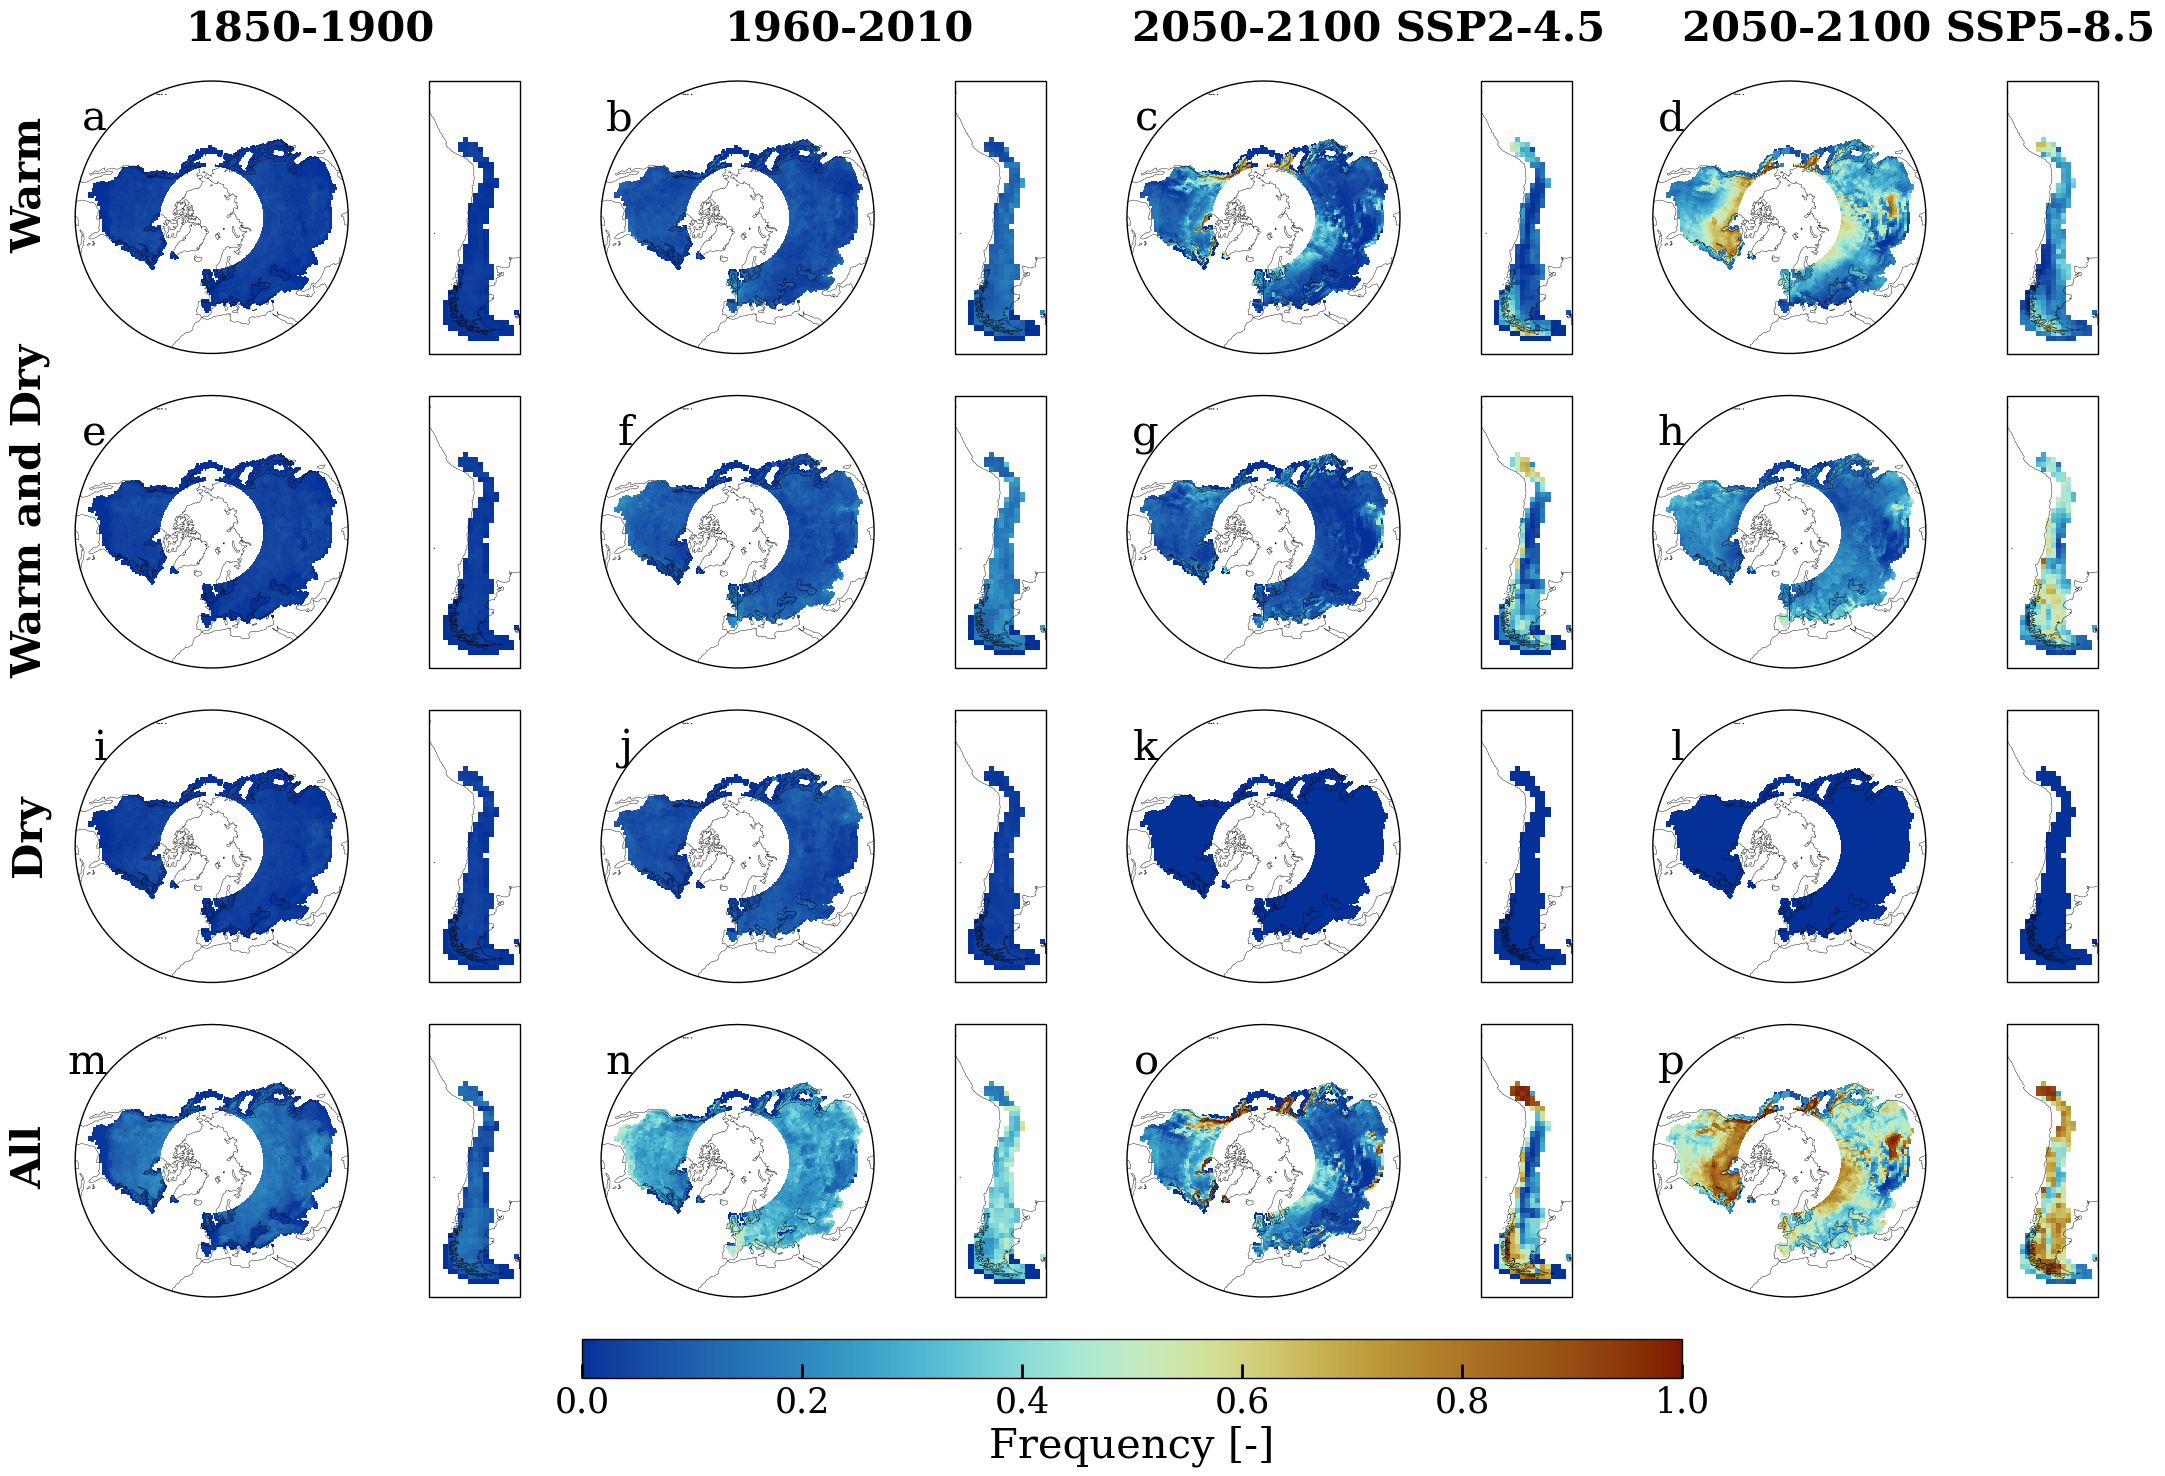

In [132]:
## FREQUENCY ## 

proj = ccrs.NorthPolarStereo()
cmap = cm.roma_r
NORM = True
nm = 30
vmin = 0
vmax = 1

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
fig = plt.figure(figsize = (22,13))
## prep data
order = [0,8,16,20,
         1,9,17,21,
         2,10,18,22,
         3,11,19,23]

X,Y = np.meshgrid(x,y)
for i,val in enumerate(order):
    data2plot = plotdata[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)
    cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())

fig.tight_layout()
cax = plt.axes([0.25, -0.03, .5, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Frequency [-]',size=30)
## text
plt.text(-0.52,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(-0.52,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-0.52,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-0.52,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')

plt.text(-0.36,34.3,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(0.13,34.3,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(0.50,34.3,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(1.00,34.3,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()
fig.savefig(homedir + 'figures/fig4_val.jpg')

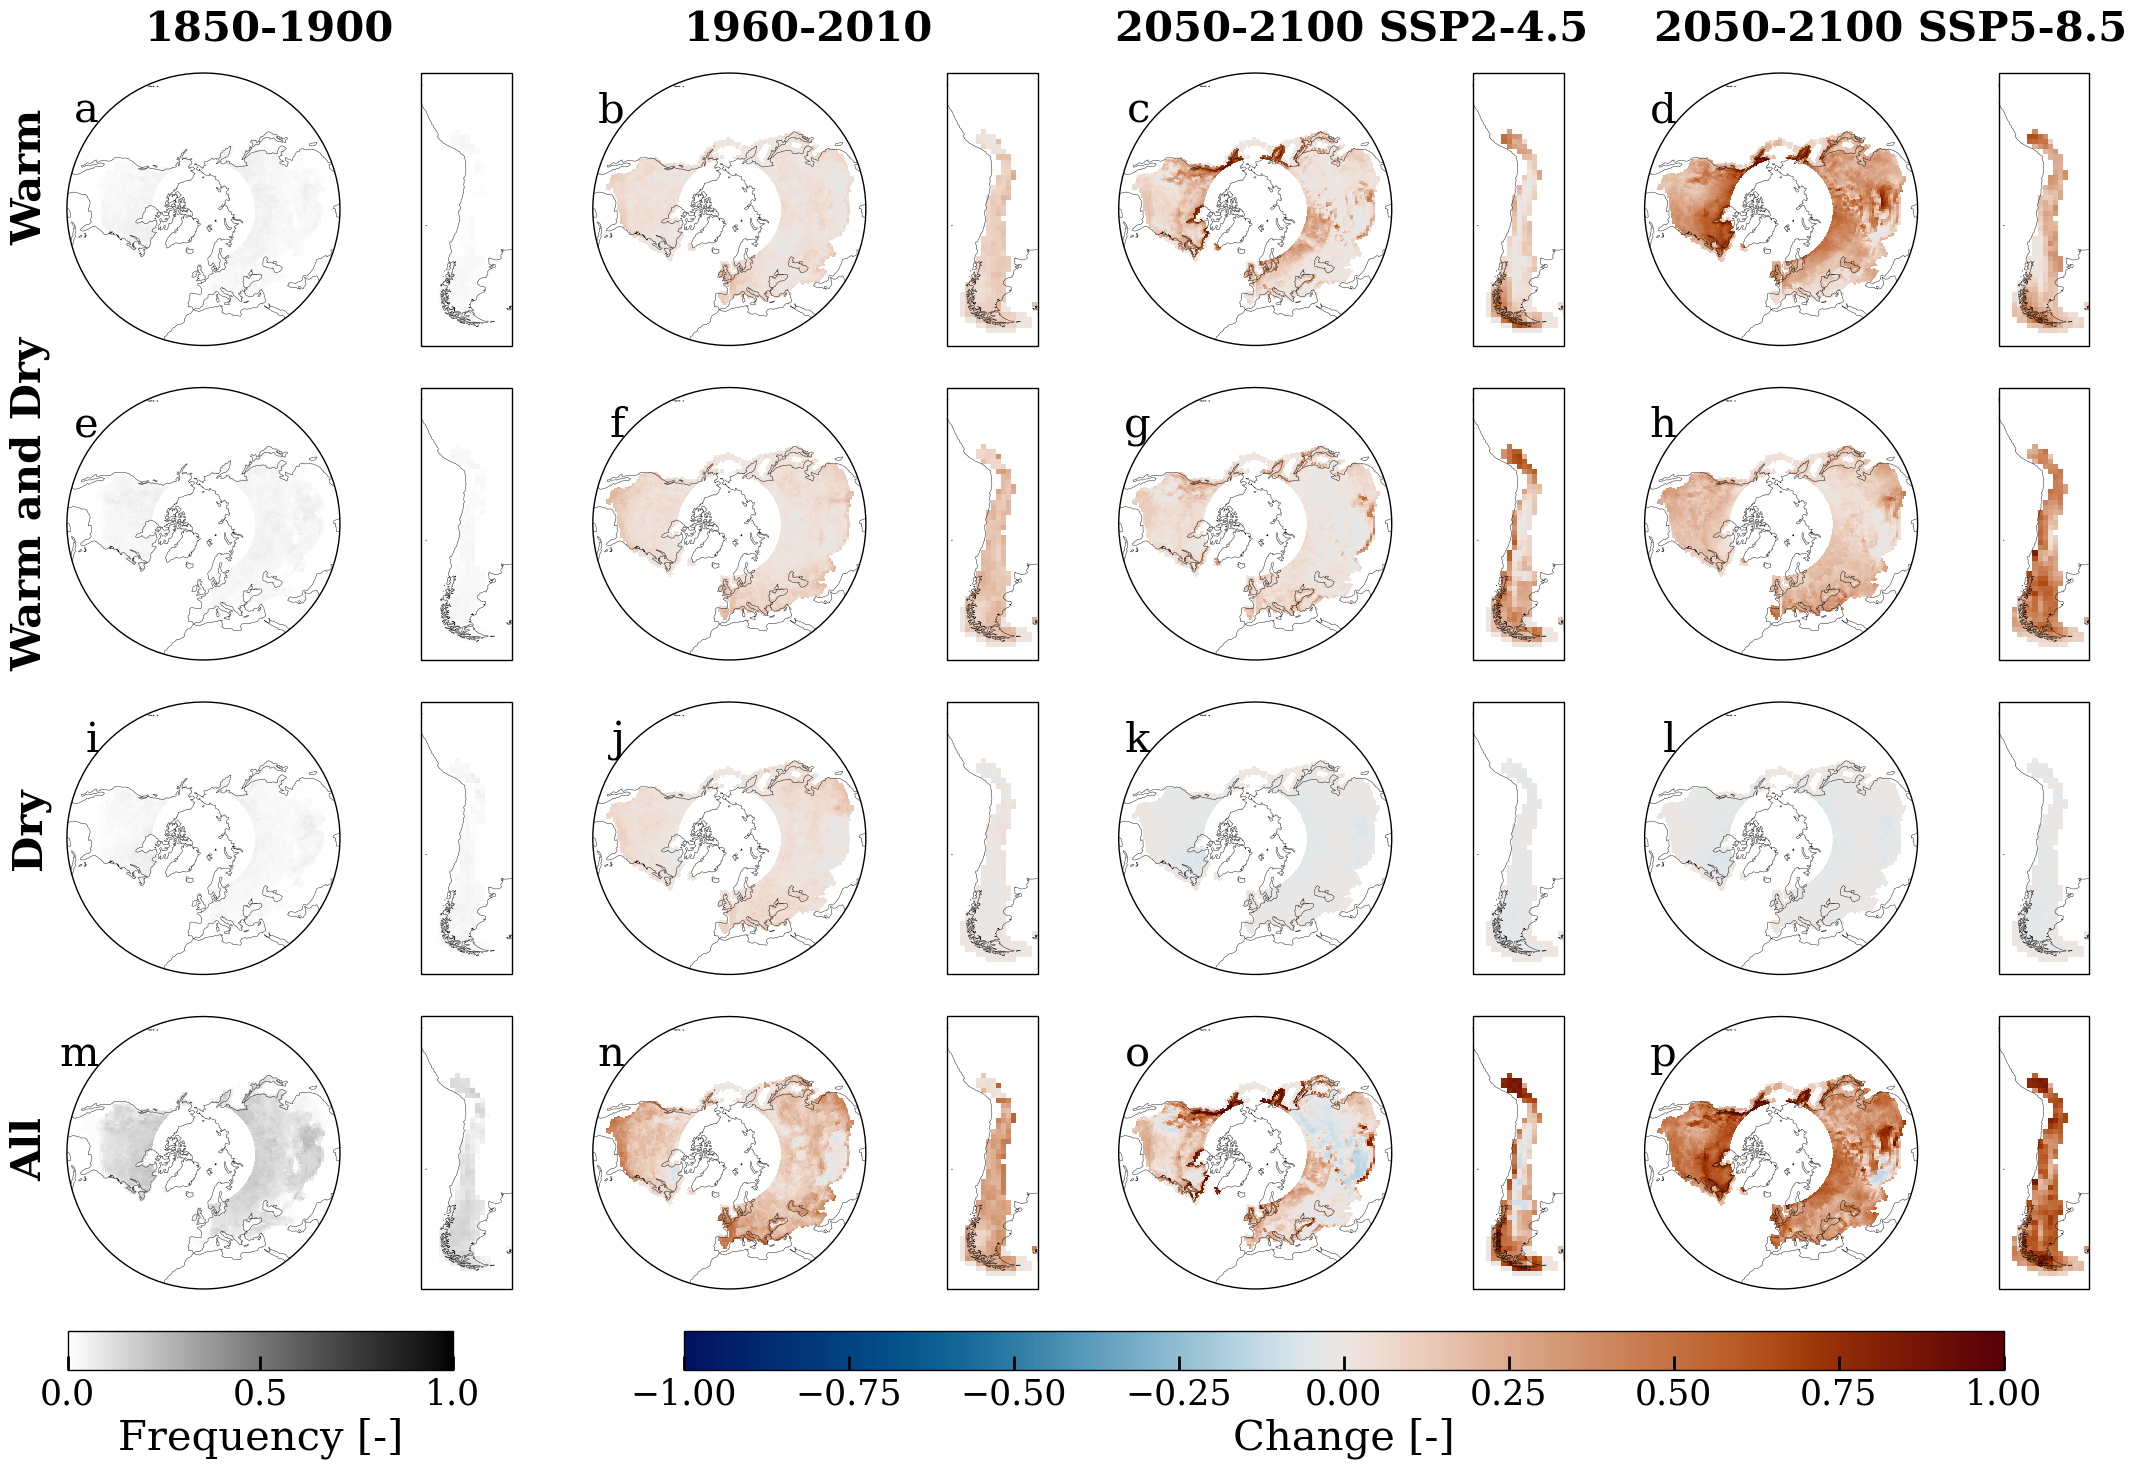

In [139]:
## FREQUENCY DIFFERENCE MAPS ## 
proj = ccrs.NorthPolarStereo()
c_cmap = cm.roma_r
from matplotlib.colors import ListedColormap, BoundaryNorm
num_steps = 9
colors = c_cmap(np.linspace(0, 1, num_steps))
discrete_cmap = ListedColormap(colors)



NORM = True
nm = 30
vmin = 0
vmax = 1

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
fig = plt.figure(figsize = (22,13))
## prep data
order = [0,8,16,20,
         1,9,17,21,
         2,10,18,22,
         3,11,19,23]

baseline = plotdata[0]/(12*50)
X,Y = np.meshgrid(x,y)
for i,val in enumerate(order):
    data2plot = plotdata[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)
    if val > 4:
        data2plot = data2plot - baseline
        cmap = cm.vik
        vmin = -1
        vmax = 1
        cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)

    if val < 4:
        baseline = data2plot
        cmap = cm.bilbao
        cmap = cm.grayC
        vmin = 0
        vmax = 1
        cb1 = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)


    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())

fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03]) ## left, bottom, width, height
cax1 = plt.axes([0.02, -0.03, .175, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Change [-]',size=30)

cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Frequency [-]',size=30)


## text
x_base = -0.15
plt.text(x_base,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = 0.2
x_space = 1.4
plt.text(x_base ,34.1,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,34.1,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space , 34.1,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,34.1,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')
plt.show()

fig.savefig(homedir + 'figures/fig4_diff.jpg')

In [146]:
## Print stats
order = [0,8,16,20,
         1,9,17,21,
         2,10,18,22,
         3,11,19,23]
##
# 1: all droughts frequency
print('hist baseline to ssp2-4.5 eoc all droughts : ', round(np.nanmean((plotdata[19]- plotdata[3])) /np.nanmean(plotdata[3]) * 100 ,2), 'percent, sd',
        round(np.nanstd((plotdata[19]- plotdata[3])/np.nanmean(plotdata[3])),2))
print('hist baseline to ssp5-8.5 eoc all droughts : ', round(np.nanmean((plotdata[23] - plotdata[3]))/np.nanmean(plotdata[3]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[23]- plotdata[3]) / np.nanmean(plotdata[3])),2))

# 1: all droughts frequency
print('hist baseline to ssp2-4.5 eoc all droughts : ', round(np.nanmean((plotdata[19]/(12*50)- plotdata[3]/(12*50))),2), '[-], sd',
        round(np.nanstd((plotdata[19]/(12*50)- plotdata[3]/(12*50))),2))
print('hist baseline to ssp5-8.5 eoc all droughts : ', round(np.nanmean((plotdata[23]/(12*50) - plotdata[3]/(12*50))) ,2), '[-], percent, sd', 
      round(np.nanstd((plotdata[23]/(12*50)- plotdata[3]/(12*50))),2))

### 

print('\nmodern droughts')
print('modern percent warm or warm and dry: ', round(np.nanmean((plotdata[8]+plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[8]+plotdata[9])/(plotdata[11]))* 100,2))

print('modern percent dry or warm and dry: ', round(np.nanmean((plotdata[10]+plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[10]+plotdata[9])/(plotdata[11]))* 100,2))

print('modern percent warm alone: ', round(np.nanmean((plotdata[8])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[8])/(plotdata[11]))* 100,2))

print('modern percent dry alone: ', round(np.nanmean((plotdata[10])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[9])/(plotdata[10]))* 100,2))

print('modern percent warm and dry alone: ', round(np.nanmean((plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[9])/(plotdata[11]))* 100,2))


# 2: how many were warm?
print('\nwarm stats')
print('historical percent warm or warm and dry: ', round(np.nanmean((plotdata[0]+plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[0] + plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent dry or warm and dry: ', round(np.nanmean((plotdata[2]+plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[2] + plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent warm alone: ', round(np.nanmean((plotdata[0])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[0])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent dry alone: ', round(np.nanmean((plotdata[2])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[2])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('historical percent warm and dry: ', round(np.nanmean((plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[1])/(plotdata[0] + plotdata[1] +plotdata[2]))* 100,2))

print('eoc percent warm ssp2-4.5: ', round(np.nanmean((plotdata[16] + plotdata[17])/(plotdata[16] + plotdata[17] +plotdata[18] ))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[16] + plotdata[17])/(plotdata[16] + plotdata[17] +plotdata[18]))* 100,2))

print('eoc percent warm ssp5-8.5: ', round(np.nanmean((plotdata[20] + plotdata[21])/(plotdata[20] + plotdata[21] +plotdata[22] ))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[20] + plotdata[21])/(plotdata[20] + plotdata[21] +plotdata[22]))* 100,2))

print('\nfuture stats')

print('ssp245 eoc percent dry or warm and dry: ', round(np.nanmean((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2))
print('ssp585 eoc percent dry or warm and dry: ', round(np.nanmean((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2))

# 2 change in dry drought
print ('\ndry drought change')
print('hist baseline to ssp2-4.5 eoc dry droughts : ', round(np.nanmean((plotdata[18] - plotdata[2]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[18]- plotdata[2]) / np.nanmean(plotdata[2])),2))
print('hist baseline to ssp5-8.5 eoc dry droughts : ', round(np.nanmean((plotdata[22] - plotdata[2]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[22]- plotdata[2]) / np.nanmean(plotdata[2])),2))

print('modern to ssp2-4.5 eoc dry droughts : ', round(np.nanmean((plotdata[18] - plotdata[10]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[18]- plotdata[10]) / np.nanmean(plotdata[10])),2))
print('modern to ssp5-8.5 eoc dry droughts : ', round(np.nanmean((plotdata[22] - plotdata[10]))/np.nanmean(plotdata[2]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata[22]- plotdata[10]) / np.nanmean(plotdata[10])),2))


print('modern - ssp245 eoc percent dry or warm and dry: ', 
      round(np.nanmean((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[18]+plotdata[17])/(plotdata[19]))* 100,2))

print('modern - ssp585 eoc percent dry or warm and dry: ', 
      round(np.nanmean((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2), 'percent, sd',
     round(np.nanstd((plotdata[21]+plotdata[22])/(plotdata[23]))* 100,2))

#3: how much severity increase?
print('\nchange in severity')
print('hist baseline to ssp2-4.5 eoc all droughts sev :',  
      round((np.nanmean((plotdata_sev[19]- plotdata_sev[3])/12/50)),2) , 'SWEI value, ',
      round((np.nanstd((plotdata_sev[19]- plotdata_sev[3])/12/50)),2) , 'sd, ',
      round(np.nanmean((plotdata_sev[19]- plotdata_sev[3])) /np.nanmean(plotdata_sev[3]) * 100 ,2), 'percent, sd',
        round(np.nanstd((plotdata_sev[19]- plotdata_sev[3])/np.nanmean(plotdata_sev[3])),2))
print('hist baseline to ssp5-8.5 eoc all droughts sev: ', 
      round((np.nanmean((plotdata_sev[23]- plotdata_sev[3])/12/50)),2) , 'SWEI value, ',
      round((np.nanstd((plotdata_sev[23]- plotdata_sev[3])/12/50)),2) , 'sd, ',
      round(np.nanmean((plotdata_sev[23] - plotdata_sev[3]))/np.nanmean(plotdata_sev[3]) * 100 ,2), 'percent, sd', 
      round(np.nanstd((plotdata_sev[23]- plotdata_sev[3]) / np.nanmean(plotdata_sev[3])),2))



hist baseline to ssp2-4.5 eoc all droughts :  138.32 percent, sd 2.2
hist baseline to ssp5-8.5 eoc all droughts :  398.22 percent, sd 1.8
hist baseline to ssp2-4.5 eoc all droughts :  0.14 [-], sd 0.23
hist baseline to ssp5-8.5 eoc all droughts :  0.42 [-], percent, sd 0.19

modern droughts
modern percent warm or warm and dry:  56.71 percent, sd 10.96
modern percent dry or warm and dry:  54.53 percent, sd 8.06
modern percent warm alone:  25.51 percent, sd 8.52
modern percent dry alone:  23.33 percent, sd 204.68
modern percent warm and dry alone:  31.2 percent, sd 8.03

warm stats
historical percent warm or warm and dry:  68.49 percent, sd 10.24
historical percent dry or warm and dry:  67.32 percent, sd 9.94
historical percent warm alone:  32.68 percent, sd 9.94
historical percent dry alone:  31.51 percent, sd 10.24
historical percent warm and dry:  35.81 percent, sd 11.26
eoc percent warm ssp2-4.5:  99.99 percent, sd 0.09
eoc percent warm ssp5-8.5:  100.0 percent, sd 0.0

future stats


/tmp/ipykernel_13647/1300318606.py:22: RuntimeWarning: invalid value encountered in true_divide
  print('modern percent warm or warm and dry: ', round(np.nanmean((plotdata[8]+plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
/tmp/ipykernel_13647/1300318606.py:23: RuntimeWarning: invalid value encountered in true_divide
  round(np.nanstd((plotdata[8]+plotdata[9])/(plotdata[11]))* 100,2))
/tmp/ipykernel_13647/1300318606.py:25: RuntimeWarning: invalid value encountered in true_divide
  print('modern percent dry or warm and dry: ', round(np.nanmean((plotdata[10]+plotdata[9])/(plotdata[11]))* 100,2), 'percent, sd',
/tmp/ipykernel_13647/1300318606.py:26: RuntimeWarning: invalid value encountered in true_divide
  round(np.nanstd((plotdata[10]+plotdata[9])/(plotdata[11]))* 100,2))
/tmp/ipykernel_13647/1300318606.py:28: RuntimeWarning: invalid value encountered in true_divide
  print('modern percent warm alone: ', round(np.nanmean((plotdata[8])/(plotdata[11]))* 100,2), 'percent, sd',
/tmp/ip

In [ ]:
from scipy import stats
mask = ~np.isnan(plotdata[19])
res = stats.ttest_ind(plotdata[19][mask], plotdata[3][mask], 
                      equal_var=True)

display(res)


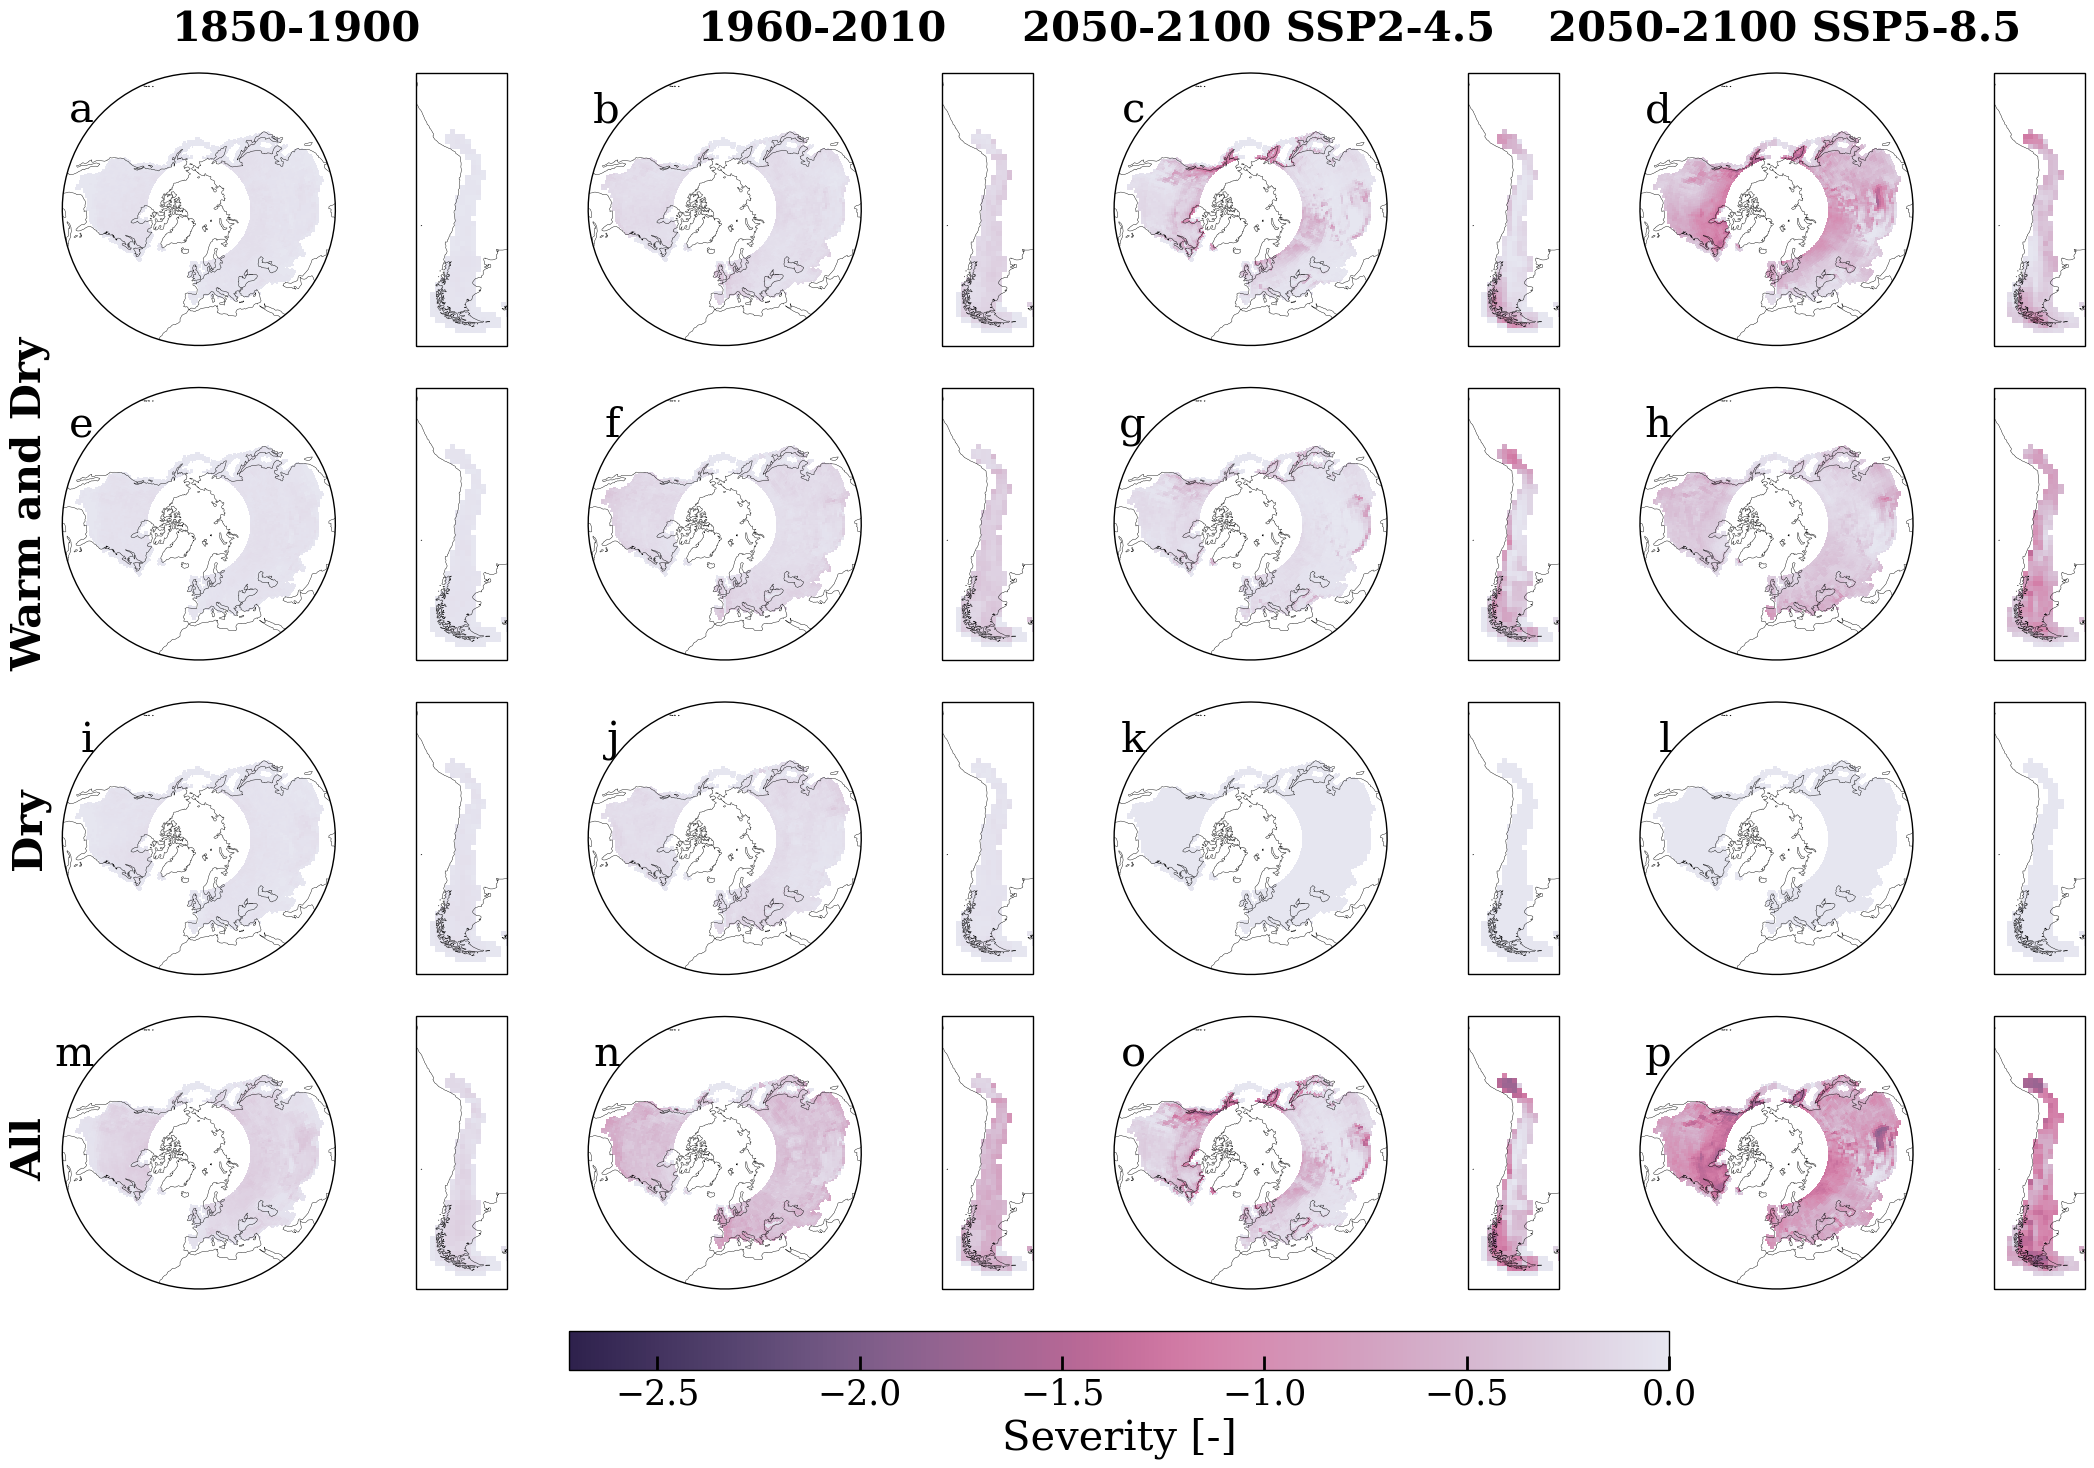

In [135]:
## SEVERITY ##
proj = ccrs.NorthPolarStereo()
cmap = cm.acton
NORM = True
nm = 50
vmin = -np.e
vmax = 0

fig = plt.figure(figsize = (22,13))

for i,val in enumerate(order):
    data2plot = plotdata_sev[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)
    cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())
fig.tight_layout()
cax = plt.axes([0.25, -0.03, .5, 0.03])
cax.tick_params(axis="x", labelsize=25)

fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Severity [-]',size=30)
## textplt.text(-4.1,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(-4.1,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-4.1,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(-4.1,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')

plt.text(-3.7,34.1,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(-2.4,34.1,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(-1.6, 34.1,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(-0.3,34.1,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')

plt.show()
fig.savefig(homedir + 'figures/fig5_val.jpg')

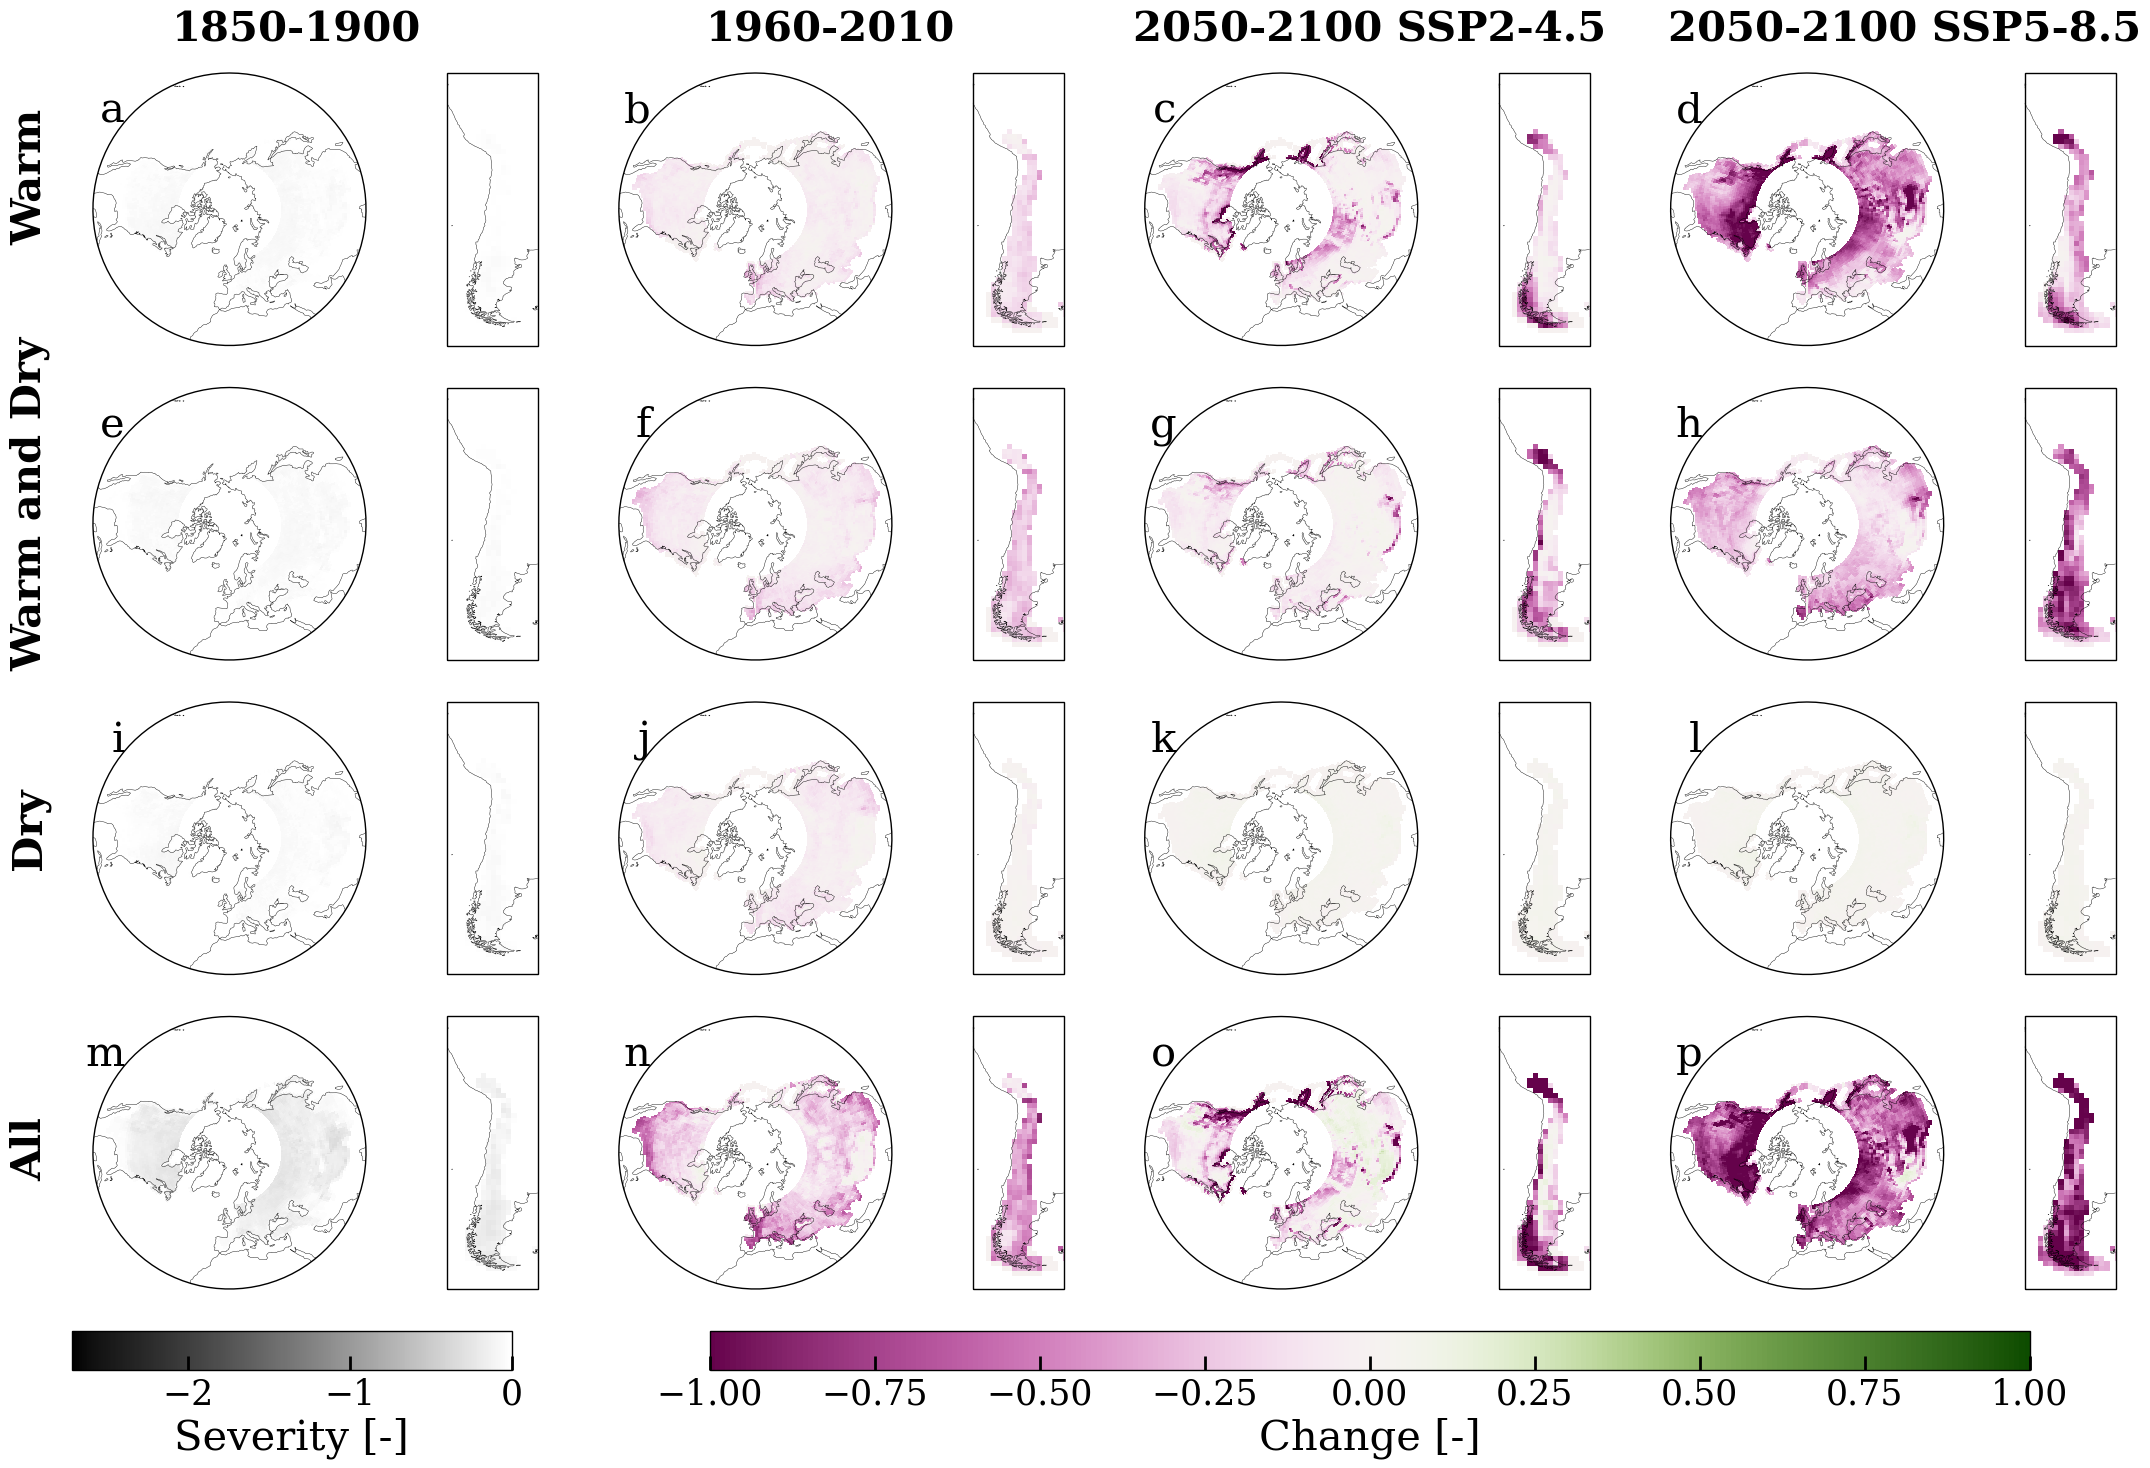

In [140]:
## SEVERITY ##
proj = ccrs.NorthPolarStereo()
cmap = cm.acton
NORM = True
nm = 50
vmin = -np.e
vmax = 0

fig = plt.figure(figsize = (22,13))

baseline = plotdata_sev[0]/(12*50)
for i,val in enumerate(order):
    data2plot = plotdata_sev[val]
    data2plot = data2plot/(12*50)
    ax = fig.add_subplot(4,8,2*i+1,projection=proj)

    if val > 4:
        data2plot = data2plot - baseline
        cmap = cm.bam
        vmin = -1
        vmax = 1
        cb = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    if val < 4:
        baseline = data2plot
        cmap = cm.grayC_r
        vmin = -np.e
        vmax = 0    
        cb1 = ax.pcolormesh(X,Y,data2plot, cmap = cmap, transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)

    ## add letter labels, hacky way to get the letter outside the plot
    polarCentral_set_latlim([20,90],ax)
    ax.text(230,20,chr(i + 97),fontsize=30, transform = ccrs.PlateCarree(),in_layout = False,ha='right')
    ax.coastlines(lw=0.3)
    ax = fig.add_subplot(4,8,2*i+2,projection=ccrs.PlateCarree())
    ax.pcolormesh(X,Y, data2plot,cmap = cmap,transform = ccrs.PlateCarree(), vmin = vmin, vmax = vmax)
    ax.coastlines(lw=0.3)
    ax.set_extent([-80,-60,-60,0],crs = ccrs.PlateCarree())

fig.tight_layout()
cax = plt.axes([0.3, -0.03, .6, 0.03]) ## left, bottom, width, height
cax1 = plt.axes([0.01, -0.03, .2, 0.03])

cax.tick_params(axis="x", labelsize=25)
fig.colorbar(cb, cax = cax, orientation = 'horizontal', fraction = 0.15).set_label(label='Change [-]',size=30)

cax1.tick_params(axis="x", labelsize=25)
fig.colorbar(cb1, cax = cax1, orientation = 'horizontal', fraction = 0.15).set_label(label='Severity [-]',size=30)

## text
x_base = -3.1
plt.text(x_base,29.1,'Warm', fontsize=30, rotation = 90, weight = 'bold')
plt.text(x_base,18.2,'Warm and Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,13.1,'Dry', fontsize=30, rotation = 90,weight = 'bold')
plt.text(x_base,5.1,'All', fontsize=30, rotation = 90,weight = 'bold')
x_base = -2.1
y_top = 34.1
x_space = 3.3
plt.text(x_base,y_top,'1850-1900', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + x_space ,y_top,'1960-2010', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 1.8 * x_space , y_top,'2050-2100 SSP2-4.5', fontsize=30, rotation = 0,weight = 'bold')
plt.text(x_base + 2.8 * x_space ,y_top,'2050-2100 SSP5-8.5', fontsize=30, rotation = 0,weight = 'bold')

plt.show()
fig.savefig(homedir + 'figures/fig5_diff.jpg')
